## ARIMA Models

ARIMA stands for Autoregressive Integrated Moving Average. Compared with the above model it uses a linear combination of past time steps, and moving averages to predict t.


## Contents 
1. ARIMA parameters analysis
2. ARIMA multi-step taining and evaluation


#### ARIMA Models Evaluated
1. Multi-setp output ARIMA






ARIMA takes only a stationary time series. As explored in the ***DATA ANALYSIS*** notebook the load data can be made stationary by ***ANALYSIS RESULTS***



We will use the ARIMA model from statsmodels.api which takes the following arguments:
- p: is the number of lag observations in the model and can be estimated from Autocorrelation plots
- d: the number of times raw observations are differenced in order to make the series stationary. This is determined with a Dicky-Fuller test.
- q: the side of the moving average window. The order of moving average.


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
%matplotlib inline
sns.set_style('dark')

#import libraries for statistical analysis
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from sklearn.metrics import mean_squared_error


#import libraries for parallel processing
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

#import custom utils including persistence testbench
from model_persistence import get_persistence_dataset, train_test_split, walk_forward_evaluation, calculate_errors, plot_error

In [2]:
#load the dataset and crete the train and test sets.
data = get_persistence_dataset()

#split using default date 2017-12-31
train, test = train_test_split(data)
train.head(3)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,...,24672.0,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0
2015-01-02,27070.0,24935.0,23214.0,22540.0,22096.0,22066.0,22275.0,23025.0,23699.0,25834.0,...,29241.0,27973.0,27320.0,27157.0,29045.0,31967.0,33266.0,33668.0,32426.0,29705.0
2015-01-03,25564.0,23584.0,22194.0,21296.0,21145.0,21316.0,21674.0,22127.0,22756.0,24654.0,...,26416.0,25362.0,24770.0,24501.0,24992.0,27964.0,29694.0,29874.0,28979.0,26863.0


### ARIMA Parameter Analysis


We will use the ARIMA model from statsmodels.api. The ARIMA takes three arguments p, d, q and represent the model's lags, differncing, and moving window size. Arriving at their inital values is done via the box-jenkins method described below:
- p: The number of lag observations in the model and can be estimated from an Autocorrelation plot as the number of lag points that show deviation outside the confidence band.
- d: The number of times raw observations are differenced in order to make the series stationary. This is determined with a Dicky-Fuller test.
- q: The side of the moving average window. The order of moving average.

##### Startionay and differncing of the dataset

As described in the stationary test in the Data Analysis workbook, set of daily mean data was stationary. Here we test if the hourly data is stationary using the adfuller test over a period of 1 week of lags (24 * 7).

***Null Hypothesis***: The dataset is non-stationary and therefore differencing must be carried out.

If p-value is < 0.05 (two tailed test), we reject the null and assume that the time series is stationary.

In [13]:
#flatten the train set because the statistical model only accepts univariate series
train_flat = train.values.flatten()

In [3]:
adful_t = sm.tsa.adfuller(train_flat, maxlag=24*7)
print(pd.Series(adful_t[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic   -7.804579e+00
p-value           7.339533e-12
#Lags             1.680000e+02
Observations      2.613500e+04
dtype: float64


The p-value of the test is significantly smaller than the threshold of 0.05 and therefore we ***reject the null*** and assume a stationary dataset.

Therefore the default model paramter for d (the differncing value) is 0. We will also invesitgate a differencing paramter of 24 and 168 corresponding with the previous day, and the previous week.



##### Autocorrelation and partial autocorrelation

Descrption of the plots:

ACF - Describes the direct and indirect relationships between laging (shifted) autoregressive features. I.e. the relationships between t, t-1, t-2, t-3 etc. taking into account the interrelatinships between features, in this case t-1 and t-2, t-2 and t-3 etc.

PACF - Describes only the direct relationships between lagging (shifted) and autoregressive features.

p (AR): Determining the autoregressive hyperparameter value p, is best described as the number of lags beyond which there is no significant relationship. This is seen in the ACF as the point at which plot values lie outside the significance band (light blue horizontal band)

q (MR): Determining the moving average hyperparameter value q, is described as the direct relationship with the lag feature and the feature. 

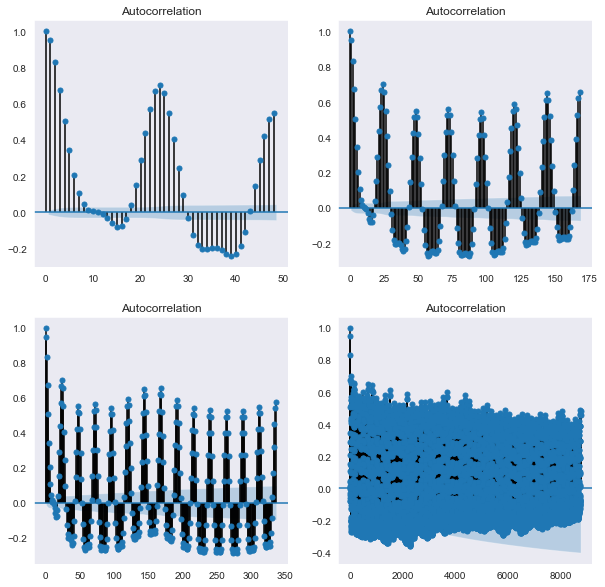

In [65]:
#plot the ACF 
fig, axs = plt.subplots(2,2, figsize=(10,10))

lags = [48, 24*7, 24*14, 24*365]

for lag, ax in zip(lags, axs.flatten()):
    plot_acf(train_flat, lags=lag, ax=ax)
plt.show()

The autocorrelation plot shows significant positive corelations in the first 9 lags. However in this problem we are attempting to forecast the next 24 hours and using a lag less than 24 does not capture the full context of a short-term day ahead forecast.

The cyclic pattern of the autoregressive features is apprent in the plots. In the ARIMA model the assumption is that beyond the chosen lag point (p), there is no correlation. Observing the bottom right plot we see this point occurs around approximately 4000 lags (approximately 1/2 year).

For the scope of this project calculating with 4000 lags is not feasible. We will focus on lag points 24 (previous day), 48 (previous two days), 168 (previous week).

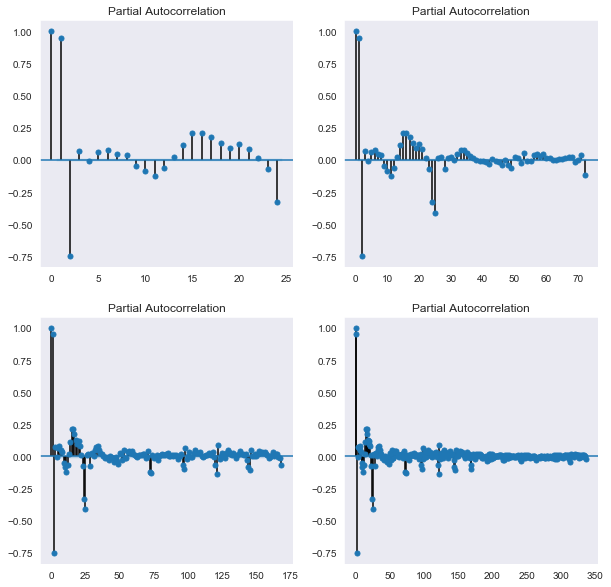

In [68]:
#plot the ACF 
fig, axs = plt.subplots(2,2, figsize=(10,10))

lags = [24, 24*3, 24*7, 24*14]

for lag, ax in zip(lags, axs.flatten()):
    plot_pacf(train_flat, lags=lag, ax=ax)
plt.show()

The partial autocorrelation plot shows that beyond 24 lags there is no signficant partial autocorrelation. Considering this we will investigate lags 2, 3, 12, and 24 for the moving average values.

##### Summary of hyperparmeter values to investigate

- p (autoregressive): 24, 48, 168
- d (differncing): 0, 24, 168
- q (moving average): 0, 2, 3, 12, 24

### ARIMA Model: Baselines

The baseline parametres for the ARIMA model are chosen as (p, d, q) = (24, 0, 0). This implies 24 autoregressive features are computed for each day in the training set. Because this is computationally intensive we will run this for 1/365 test cycle of the walk forward validation and log the training time.

In [15]:
#run the model for one forecasting period and estimate how long it will take to implement

def test_run_ARIMA(train_flat):
    #setup a model instence
    model_24 = ARIMA(train_flat, order=(24, 0, 0))

    #fit the model
    model_fit_24 = model_24.fit()

    #run the 24 interval forecast and return the operation time
    forecast_24, std_24, intervals_24 = model_fit_24.forecast(24)
    
    return forecast_24, std_24, intervals_24
    
%time forecast_24, std_24, intervals_24 = test_run_ARIMA(train_flat)    

CPU times: user 57min 2s, sys: 43.6 s, total: 57min 46s
Wall time: 15min 9s


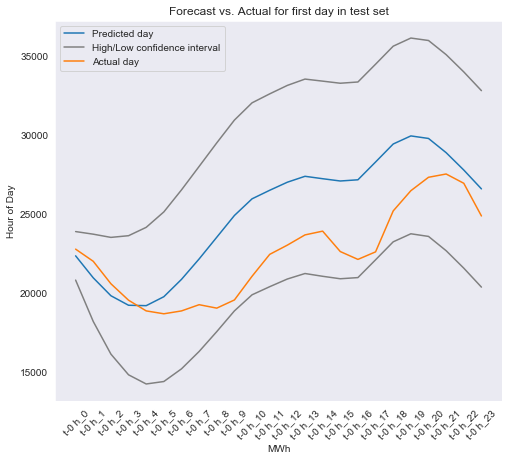

In [105]:
#plot the result and get an idea if the forecast is in the right direction
fig = plt.figure(figsize=(8,7))

plt.plot(forecast_24, label='Predicted day')
plt.plot(intervals_24[:,0], label='High/Low confidence interval', color='gray')
plt.plot(intervals_24[:,1], color='gray')
plt.plot(test.iloc[0,:], label='Actual day')
plt.xticks(rotation=45)
plt.title('ARIMA Forecast vs. Actual for first day in test set')
plt.xlabel('MWh')
plt.ylabel('Hour of Day')
plt.legend()
plt.show()

The example above shows the first test day forecast vs actual values after training on the whole 3 years of training data.

In [42]:
#calculate the root mean squared error of the single test run
print('ARIMA 1 step walk forward RMSE: {0:.2f} MWh' .format(np.sqrt(mean_squared_error(test.iloc[0,:], forecast_24))))

ARIMA 1 step walk forward RMSE: 3393.73 MWh


##### ARIMA model function

Before moving to calculate the walk forward validation on the entire training set using only one autoregressive feature. This will allow testing of the funcitons written to calcualte RMSE and plotting of hour by hour RMSE.

In [2]:
#define a model to insert into the training rig created in the persistence workbook
def arima_model(history, config):
    
    #convert dataframe to numpy array and flatten into column vector
    history_flat = history.values.flatten()
    
    p,d,q = config
    
    #initalize the ARIMA model
    model = ARIMA(history_flat, order=(p, d, q))
    
    #fit model
    model_fit = model.fit()
    
    #generate forecast for the next 24 hours
    forecast, _, _ = model_fit.forecast(24)
    
    #save the model
    #name = 'model-' + str(datetime.datetime.now()) +'.pkl'
    #model_fit.save(name)
    
    #print('Done. Model Saved.')
    
    return forecast

In [104]:
errors, errors_mean, prediction = walk_forward_evaluation(arima_model, train, test, 'arima_model', config=(1,0,0))

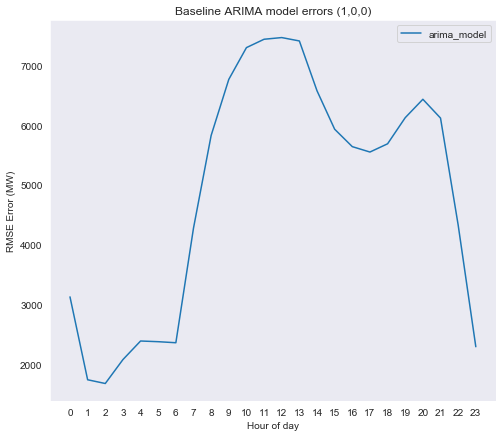

In [106]:
plot_error(errors, result_set=['arima_model'], title='Baseline ARIMA model errors (1,0,0)')

The above shows the hour by hour errors for the whole walk forward test set using one autoregressive feature. This is equivilant of forecasting using a naive function where hour 23 is used as the forecast for the following 24 hours.

### ARIMA Model: Computation Estimations

##### Full test set walk forward: computation time estimate

The baseline evaluation above fit the model on 3 years of hourly data and forecast the first day in the training set. Following the walk forward validation methodology this process is run ***for the entire test set***. Baseline time results for 1/365 of the test forecast:

CPU Time 57 min 46 s
Wall time 15 min 09 s

The process used multiple cores to complete. On an average of 4 cores for the job the total training set would take 15 min * 365 test days. Or a total of 91 hours (3.8 days).

##### Grid search hyperparameters computation time

Following the analysis of AC and PAC plots 45 combinations of hyperparmeters have been identified of interest. Assuming similar computation times for each hyperparmeter combination as the baseline the total computer time is:

***Computation time:*** 45 hyperparmeters * 91 hours = 4095 hours using 4 cores per job (4*45 cores for multicore processing.

##### Assessing implementation options

**1. Run ARIMA on a GPU**

According to [this post](https://github.com/statsmodels/statsmodels/issues/4752) the ARIMA model is not deployable on a GPU. 

The [Hyperlearn repo](https://github.com/danielhanchen/hyperlearn) did look promising as a resource that implements multithreaded processing of Sklearn, statsmodels etc. However at writing it does not support an ARIMA model implementation.

**2. Condense the training and test sets**

In the original problem formulation the walk forward validation problem was set up with 3 years of training data and 1 year test for a total of 4 years.

By dropping the training size to 1 year, and forecasting the first 3 months of the original test set we drop the total data by ~65%.

**3. Consider using SARIMAX**

The SARIMAX model is more complex, and uses mode features resulting in a larger statespace to calculate. According to the documentation the ARIMA model is mintained at minimum while the SARIMA model has newer implementations. It is not clear that the SAIRMAX is in fact a faster algorithem. In this notebook we will run a test against a ARIMA and compare

##### Computation tests on smaller dataset

Here we implement a condsened version of the walk forward validation set. The specific details of the datasets is described below:

- Train: 2017-01-01 to 2017-12-31
- Test: 2018-01-01 to 2018-03-31 
- Model: ARIMA (24,0,0) predicting the frist 1/90 days of the test set

In [25]:
#setup the train and test with a condensed training set
data = get_persistence_dataset(start='2017-01-01', stop='2018-03-31')
train_condensed, test_condensed = train_test_split(data, split_date='2017-12-31')
train_flat_condensed = train_condensed.values.flatten()

In [31]:
print('Total days in train set {}'.format(train_condensed.shape[0]))
print('Total days in test set {}'.format(test_condensed.shape[0]))

Total days in train set 365
Total days in test set 90


In [28]:
#repeat the vanilla ARIMA with 24 auroregressive features
%time forecast_ARMA, std_AMRA, intervals_AMRA = test_run_ARIMA(train_flat_condensed)

CPU times: user 31min 11s, sys: 39.9 s, total: 31min 51s
Wall time: 8min 6s


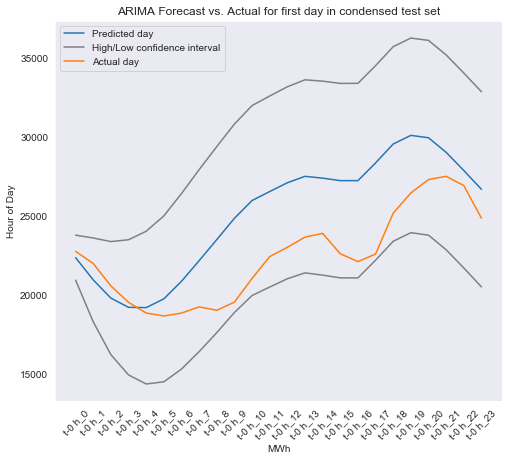

In [48]:
#plot the result and get an idea if the forecast is in the right direction
fig = plt.figure(figsize=(8,7))

plt.plot(forecast_24, label='Predicted day')
plt.plot(intervals_24[:,0], label='High/Low confidence interval', color='gray')
plt.plot(intervals_24[:,1], color='gray')
plt.plot(test.iloc[0,:], label='Actual day')
plt.xticks(rotation=45)
plt.title('ARIMA Forecast vs. Actual for first day in condensed test set')
plt.xlabel('MWh')
plt.ylabel('Hour of Day')
plt.legend()
plt.show()

In [45]:
print('ARIMA 1 step walk forward RMSE: {0:.2f} MWh' .format(np.sqrt(mean_squared_error(test_condensed.iloc[0,:], forecast_ARMA))))

ARIMA 1 step walk forward RMSE: 3393.73 MWh


##### Computation test using the SARIMAX model

As mentioned the SARIMAX model is possibly a faster implementation. Functionally the model also offers an additional layer of hyperparmeters, P/D/Q/m, pertaining to seasonality.

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.

The additional features allows us to reframe the forecasting problem to each m periods is a season. Witin the season we can set P, D, Q respectively as functions of the season. 

For the test run the trend parameters were chosen to be the same as the ARIMA. In this case (24, 0, 0). The seasonal parmaters were chosen based on knowledge of the problem.

**Baseline seasonal hyperparmeter values**
- m: 24 to represent the cyclic pattern of energy demand every 24 hours.
- P: 1 to take the autoregressive features from the previous season (i.e. previous day)
- D: 1 to consider the differncing between consecutive seasons (i.e. days)
- Q: 0 to consider that consecutive seasonal forecasts are independent


In [30]:
#test run estimation of the SARIMAX algorithem

def test_run_SARIMAX(train_flat):
    #setup a model instence
    model_SAMX = SARIMAX(train_flat, order=(24, 0, 0), seasonal_order = (1,1,0,24))

    #fit the model
    model_fit_SAMX = model_SAMX.fit()

    #run the 24 interval forecast and return the operation time
    forecast_SAMX = model_fit_SAMX.forecast(24)
    
    return forecast_SAMX


#run train with a condensed training set
data = get_persistence_dataset(start='2017-01-01', stop='2018-03-31')
train, test = train_test_split(data, split_date='2017-12-31')
train_flat_short = train.values.flatten()

%time forecast_SAMX = test_run_SARIMAX(train_flat_condensed) 

CPU times: user 27min 11s, sys: 43.8 s, total: 27min 55s
Wall time: 7min 57s


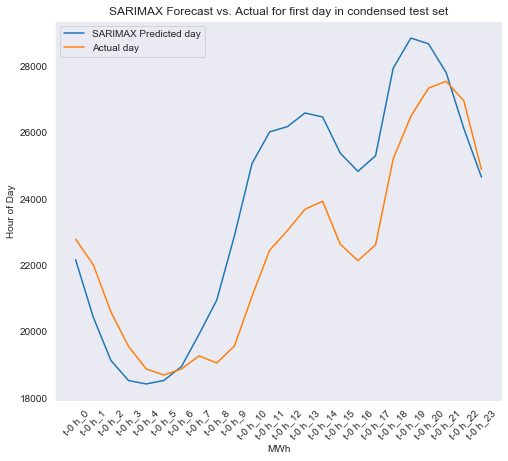

In [47]:
#evaluate SARIMAX test run and see how it compares t
#plot the result and get an idea if the forecast is in the right direction
fig = plt.figure(figsize=(8,7))

plt.plot(forecast_SAMX, label='SARIMAX Predicted day')
plt.plot(test_condensed.iloc[0,:], label='Actual day')
plt.xticks(rotation=45)
plt.title('SARIMAX Forecast vs. Actual for first day in condensed test set')
plt.xlabel('MWh')
plt.ylabel('Hour of Day')
plt.legend()
plt.show()

In [43]:
print('SARIMAX 1 step walk forward RMSE: {0:.2f} MWh' .format(np.sqrt(mean_squared_error(test_condensed.iloc[0,:], forecast_SAMX))))

ARIMA 1 step walk forward RMSE: 2162.67 MWh


#### Computational test results

|Model|Test Set|RMSE (Single Step)| Computation Time (min) | Total Time Estimated (h)|
|-----|--------|---|---|---|
|ARIMA|Full|xxxx | 15:09|91.25|
|ARIMA|Condensed|3393.73 | 08:06|12.15|
|SARIMAX|Condensed|2162.67 | 07:57|11.92|

##### Was SARIMAX really faster?

With a difference of only 9 seconds, it seems unlikely. One option to know would be to run the test several times each and measure the mean difference. However this odes not seem practical considering we are looking for a method that reduces computation load.

While SARIMAX might not have been faster, the forecast was substancially better both in terms of the RMSE on the first walk forward validation step and the look of the forecast in the plot.

Therefore we will revisit the hypertuning parameters and define new gridsearch parmeters for SARIMAX.

### Gridsearch and SARIMAX Model

Trend Terms:
- p (autoregressive): 24, 48, 168
    - Search over hourly autoregressive segemnts of 24, 48, 168
- d (differncing): 0
    - Because there is no requirement that the input is stationary with SARIMAX, differencing is now considered in the seasonal configuration.
- q (moving average): 0, 2, 3, 12, 24
    - 

Seasonal terms:

Trend term: 'n' 

- m: 24 to represent the cyclic pattern of energy demand every 24 hours.
- P: 1 to take the autoregressive features from the previous season (i.e. previous day)
- D: 1 to consider the differncing between consecutive seasons (i.e. days)
- Q: 0 to consider that consecutive seasonal forecasts are independent


In [ ]:
- p (autoregressive): 24, 48, 168
- d (differncing): 0, 24, 168
- q (moving average): 0, 2, 3, 12, 24

In [51]:
#define a model to insert into the training rig created in the persistence workbook
def sarimax_model(history, config):
    
    #convert dataframe to numpy array and flatten into column vector
    history_flat = history.values.flatten()
    
    p, d, q, P, D, Q, m = config
    
    #initalize the ARIMA model
    model = SARIMAX(history_flat, order=(p, d, q), seasonal_order=(P, D, Q, m), trend='n')
    
    #fit model
    model_fit = model.fit()
    
    #generate forecast for the next 24 hours
    forecast= model_fit.forecast(24)
    
    return forecast

##### GridSearch framework for testing

Grid searching over the identified hyperparameter space will allow us to see which configuration delivers the best forecasts.

The grid search code below is adapted from Jason Brownlee's impelmentation in his Book: Deep Learning Time Series Forecasting.

In [3]:
def score_model(model, data, split_date, cfg):
    """
    Function that
    - splits the data into test and train
    - tries to initalize an intence of the model
    - prints and returns the model errors, mean rmse, and predictions
    
    """
    
    result = None
    errors = None
    predictions = None
    
    #get the name of the model
    name = str(model)
    #get the model parameters
    key = str(cfg)

    #initalize the train and test data
    train, test = train_test_split(data, split_date=split_date)
    
    try:
        with catch_warnings():
            filterwarnings('ignore')
            
            #run walk forward and return rmse, errors, and forecast
            result, errors, predictions = walk_forward_evaluation(model, train, test, name, config=cfg)

    except:
        print('Bad config' + str(cfg))
    
    if result is not None:
        print(' Model {}: {}'.format(key, result))
    
    return (key, result, errors, predictions)

In [4]:
def grid_search(model, data, cfg_list, split_date, parallel=True):
    """
    Grid search function
    - launches parallel jobs according to number of cpus available
    - one job per model configuration 
    """

    
    scores = []

    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), verbose=10, backend='multiprocessing')
        #set tasks into the buffer
        tasks = (delayed(score_model)(model, data, split_date, cfg) for cfg in cfg_list)
        #execute tasks in order
        scores = executor(tasks)
    else:
        for cfg in cfg_list:
            score = score_model(model, data, split_date, cfg)

        scores.append(score)
    
    #remove the scores with no values
    scores = [r for r in scores if r[1] != None]
    
    # sort configs by rmse ascending so lowest first
    scores.sort(key=lambda tup: tup[1])
    
    #scores contains the configuration, error_rmse, errors, predictions
    return scores

In [110]:
# function to create the model configurations to search over.
def arima_configs(t_lags, t_diffs, t_mas, s_lags, s_diffs, s_mas, s_ms):
    configs = list()
    for t_lag in t_lags:
        for t_diff in t_diffs:
            for t_ma in t_mas:
                for s_lag in s_lags:
                    for s_diff in s_diffs:
                        for s_ma in s_mas:
                            for s_m in s_ms:
                                cfg = [t_lag, t_diff, t_ma, s_lag, s_diff, s_ma, s_m]
                                configs.append(cfg)
    return configs

##### Collect scores and save to a csv

Before launching the job in the cloud want to be able to save and revisit the results.

The scores tuple saves the data in the form (configuration, RMSE, RMSE hourly errors, forecast).    

In [123]:
def save_all_results(scores):
    
    #break apart the scores tuple
    model_cfg = []
    rmse_list = []
    hourly_errors = []
    forecasts = []

    #assign each element in scores to its own array
    for config, rmse, hs, fs in scores:
        model_cfg.append(config)
        rmse_list.append(rmse)
        hourly_errors.append(hs)
        forecasts.append(fs)
        
        
    #combine model id and rmse results in datframe
    model_names = pd.concat([pd.Series(model_cfg), pd.Series(rmse_list)], axis=1)
    model_names.columns = ['model_cfg', 'total_rmse']

    #generate name and save the summary json file
    name_name = 'sarimax_summary_' + str(datetime.datetime.now()) + '.json'
    model_names.to_json('./results/' + name_name)
    
    for m_id, h_error, f in zip(model_cfg, hourly_errors, forecasts):
        #set the name of the model
        model_id_errors = 'sarimax_errors'+ str(m_id) + "_"+ str(datetime.datetime.now())+'.json'
        model_id_forecasts = 'sarimax_forecasts'+ str(m_id) + "_"+ str(datetime.datetime.now())+'.json'
       
    
        #save the hourly errors
        h_error.to_json('./results/hourly_errors/' + model_id_errors)
        
        #save the forecast results
        f.to_json('./results/forecasts/' + model_id_forecasts)


##### Testing the grid search function

The 

In [120]:
def test_run_sarimax_gridsearch():

    data = get_persistence_dataset(start='2018-01-01', stop='2018-03-31')

    model = sarimax_model

    t_lags = [24, 48]
    t_diffs = [0, 1]
    t_mas = [0, 1]

    s_lags = [1]
    s_diffs = [1]
    s_mas = [0]
    s_ms = [24]


    cfg_list = arima_configs(t_lags, t_diffs, t_mas, s_lags, s_diffs, s_mas, s_ms)
    split_date = '2018-03-01'
    %time scores = grid_search(model, data, cfg_list, split_date, parallel=True)

    save_all_results(scores)
    
    print('done')

In [113]:
test_run_sarimax_gridsearch()

[Parallel(n_jobs=8)]: Using backend MultiprocessingBackend with 8 concurrent workers.


Bad config[2, 0, 0, 1, 0, 0, 1]
Bad config[2, 0, 1, 1, 0, 0, 1]


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.7s remaining:    5.0s


Walk forward finished
 Model [1, 1, 0, 1, 0, 0, 1]: 6640.879644664686


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    8.2s remaining:   13.7s


Walk forward finished
 Model [1, 1, 1, 1, 0, 0, 1]: 6526.418094125199


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:   14.1s remaining:   14.1s


Walk forward finished
 Model [2, 1, 0, 1, 0, 0, 1]: 6441.872881504437


[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   14.8s remaining:    8.9s


Walk forward finished
 Model [1, 0, 0, 1, 0, 0, 1]: 20473.938545620495


[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:   19.5s remaining:    6.5s


Walk forward finished
 Model [1, 0, 1, 1, 0, 0, 1]: 7340.106580532975
Walk forward finished
 Model [2, 1, 1, 1, 0, 0, 1]: 3724.219015773335
CPU times: user 150 ms, sys: 158 ms, total: 308 ms
Wall time: 41 s
done


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   40.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   40.7s finished


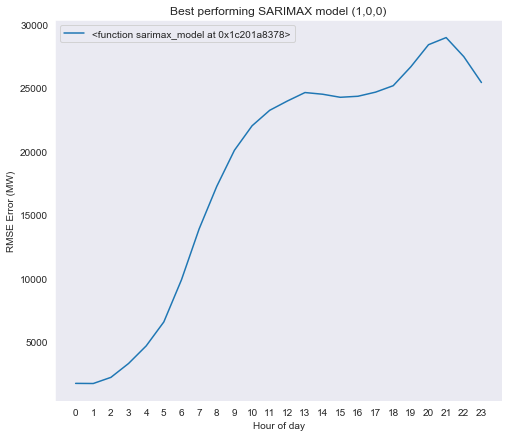

In [119]:
#plot the hourly errors from the best result
plot_error(scores[0][2], result_set=[scores[0][2].columns[0]], title='Best performing SARIMAX model (1,0,0)')

###### Return the json files and look at the results


In [121]:
f_check = pd.read_json('./results/forecasts/sarimax_forecasts[1, 0, 0, 1, 0, 0, 1]_2019-09-04 17:40:04.842382.json')

In [122]:
f_check

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
2018-03-02,26564.304778,24356.964627,22332.509062,20475.825175,18773.045981,17211.447918,15779.356773,14466.061326,13261.73409,12157.35856,...,7867.979088,7211.623512,6609.84022,6058.105289,5552.26882,5088.524087,4663.379231,4273.631276,3916.342293,3588.817518
2018-03-03,26564.304778,24356.964627,22332.509062,20475.825175,18773.045981,17211.447918,15779.356773,14466.061326,13261.73409,12157.35856,...,7867.979088,7211.623512,6609.84022,6058.105289,5552.26882,5088.524087,4663.379231,4273.631276,3916.342293,3588.817518
2018-03-04,26564.304778,24356.964627,22332.509062,20475.825175,18773.045981,17211.447918,15779.356773,14466.061326,13261.73409,12157.35856,...,7867.979088,7211.623512,6609.84022,6058.105289,5552.26882,5088.524087,4663.379231,4273.631276,3916.342293,3588.817518
2018-03-05,26564.304778,24356.964627,22332.509062,20475.825175,18773.045981,17211.447918,15779.356773,14466.061326,13261.73409,12157.35856,...,7867.979088,7211.623512,6609.84022,6058.105289,5552.26882,5088.524087,4663.379231,4273.631276,3916.342293,3588.817518
2018-03-06,26564.304778,24356.964627,22332.509062,20475.825175,18773.045981,17211.447918,15779.356773,14466.061326,13261.73409,12157.35856,...,7867.979088,7211.623512,6609.84022,6058.105289,5552.26882,5088.524087,4663.379231,4273.631276,3916.342293,3588.817518
2018-03-07,26564.304778,24356.964627,22332.509062,20475.825175,18773.045981,17211.447918,15779.356773,14466.061326,13261.73409,12157.35856,...,7867.979088,7211.623512,6609.84022,6058.105289,5552.26882,5088.524087,4663.379231,4273.631276,3916.342293,3588.817518
2018-03-08,26564.304778,24356.964627,22332.509062,20475.825175,18773.045981,17211.447918,15779.356773,14466.061326,13261.73409,12157.35856,...,7867.979088,7211.623512,6609.84022,6058.105289,5552.26882,5088.524087,4663.379231,4273.631276,3916.342293,3588.817518
2018-03-09,26564.304778,24356.964627,22332.509062,20475.825175,18773.045981,17211.447918,15779.356773,14466.061326,13261.73409,12157.35856,...,7867.979088,7211.623512,6609.84022,6058.105289,5552.26882,5088.524087,4663.379231,4273.631276,3916.342293,3588.817518
2018-03-10,26564.304778,24356.964627,22332.509062,20475.825175,18773.045981,17211.447918,15779.356773,14466.061326,13261.73409,12157.35856,...,7867.979088,7211.623512,6609.84022,6058.105289,5552.26882,5088.524087,4663.379231,4273.631276,3916.342293,3588.817518
2018-03-11,26564.304778,24356.964627,22332.509062,20475.825175,18773.045981,17211.447918,15779.356773,14466.061326,13261.73409,12157.35856,...,7867.979088,7211.623512,6609.84022,6058.105289,5552.26882,5088.524087,4663.379231,4273.631276,3916.342293,3588.817518


###### Time estimation of model computation

In [16]:
#### grid search parameters

lags = [24, 48, 168]
diffs = [0, 24, 168]
mas = [0, 2, 3, 12, 24]

len(grid_search(lags, diffs, mas))

45

In [23]:
%time grid_search(lags, diffs, mas)

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 21 µs


[[24, 0, 0],
 [24, 0, 2],
 [24, 0, 3],
 [24, 0, 12],
 [24, 0, 24],
 [24, 24, 0],
 [24, 24, 2],
 [24, 24, 3],
 [24, 24, 12],
 [24, 24, 24],
 [24, 168, 0],
 [24, 168, 2],
 [24, 168, 3],
 [24, 168, 12],
 [24, 168, 24],
 [48, 0, 0],
 [48, 0, 2],
 [48, 0, 3],
 [48, 0, 12],
 [48, 0, 24],
 [48, 24, 0],
 [48, 24, 2],
 [48, 24, 3],
 [48, 24, 12],
 [48, 24, 24],
 [48, 168, 0],
 [48, 168, 2],
 [48, 168, 3],
 [48, 168, 12],
 [48, 168, 24],
 [168, 0, 0],
 [168, 0, 2],
 [168, 0, 3],
 [168, 0, 12],
 [168, 0, 24],
 [168, 24, 0],
 [168, 24, 2],
 [168, 24, 3],
 [168, 24, 12],
 [168, 24, 24],
 [168, 168, 0],
 [168, 168, 2],
 [168, 168, 3],
 [168, 168, 12],
 [168, 168, 24]]